In [1]:
%reload_ext autoreload
#!pip install -r requirements.txt

dataset: soliton
dataset: soliton
64 torch.Size([10, 100])


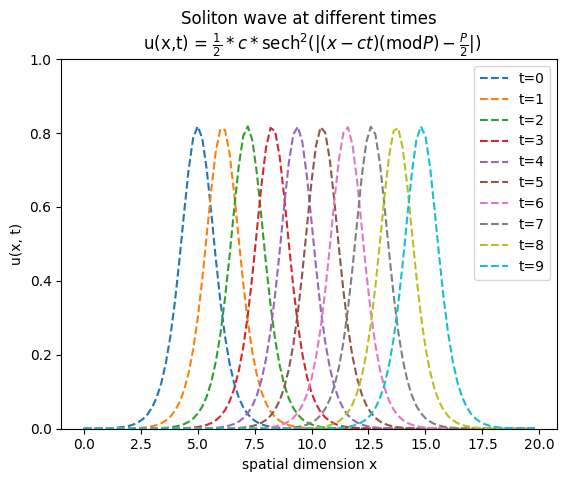

In [50]:
%autoreload
from architectures import COTGAN
from utils import log_visualizations
from trainer import cotgan_trainer, cotgan_generator, create_dataset
from metrics import energy_conservation
import numpy as np
import torch
import matplotlib.pyplot as plt

seed = 1

np.random.seed(seed)
torch.manual_seed(seed)

device = "cpu"

params_dataset = {
    "dataset": "soliton",
    "P": 20, # period
    "spatial_len": 100, # M
    "t_steps": 10,
    "t_range": [0, 6],
    "c_range": [0.5, 2],
    "difficulty": "easy",
    "eta": 6.0,
    "gamma": 1.0,
}
if params_dataset["difficulty"] == "medium":
    params_dataset["dataset"] = "medium_soliton"

trainset = create_dataset(dataset=params_dataset["dataset"],n_samples=32*2, p=params_dataset, device=device)
testset  = create_dataset(dataset=params_dataset["dataset"],n_samples=32*2, p=params_dataset)

params_dataset = params_dataset | trainset.get_params()

print(len(testset), trainset[0].shape)
def grid(P, M):
    dx = P/M
    x = torch.linspace(0, P-dx, M)
    return x, dx
x,dx = grid(params_dataset["P"], params_dataset["spatial_len"])
#plt.plot(trainset[0].T);
for t in range(params_dataset["t_steps"]):
    plt.plot(x, trainset[0][t].T, '--', label=f"t={t}")
plt.ylim(0, 1)
u_t_x = r"u(x,t) = $\frac{1}{2} *c* \mathrm{sech}^2 (| (x - c t) (\mathrm{mod}P)-\frac{P}{2}|)$"
plt.title(f"Soliton wave at different times\n {u_t_x}")
plt.xlabel("spatial dimension x")
plt.ylabel("u(x, t)")
plt.legend()

In [53]:
%autoreload
import neptune.new as neptune

run = neptune.init_run(
    project="kohmann/COTGAN",
    name="cotgan",
    tags=["soliton"],
    description="",
    source_files=["architectures.py"],
    capture_hardware_metrics=True,
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3YjFjNGY5MS1kOWU1LTRmZjgtOTNiYS0yOGI2NDdjZGYzNWUifQ==",
)

params = {
    "model_name": "model_cotgan.pt",
    "n_epochs": 10,
    "l_rate":   0.01, # for both D and G
    "l_rate_g": 0.01, # for G only
    "batch_size": 32,
    "use_opt_scheduler": False,

    "rnn_type": "GRU", # LSTM, GRU
    "dis_rnn_num_layers": 2,
    "dis_rnn_hidden_dim": 64,
    "gen_rnn_num_layers": 2,
    "gen_rnn_hidden_dim": 64,
    "J_dim": 32,
    "hidden_dim": 64, # generator: hidden dim in FC, discriminator: filters in Convolution
    "num_hidden_layers": 3, # generator fully-connected layers
    "use_bn": False, # batch normalization

    "scaling_coef": 1.0, # distance scaling (TODO(Not implemented))
    "reg_lam":      0.01, # martingale penalty coefficient
    "sinkhorn_eps": 10.0, # epsilon regularizer
    "sinkhorn_l":   100, # sinkhorn calculation iterations

    "Z_dim": 10,
    "optimizer": "Adam", # RMSprop, Adam
    "beta1": 0.5,
    "beta2": 0.9,
    "dataset": params_dataset["dataset"], # "soliton" or "sines"
    "feature_dim": trainset[0].size(1),
    "max_seq_len": trainset[0].size(0),
    "trainset_size": len(trainset),
    "testset_size": len(testset),
    "device": device,
}
params = params | params_dataset
run["parameters"] = params
run["dataset"] = params_dataset

model = COTGAN(params)
cotgan_trainer(model, trainset, params, neptune_logger=run)

from trainer import evaluate_model
evaluate_model(model, testset, run, params)

https://app.neptune.ai/kohmann/COTGAN/e/COT-339
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Using use_opt_scheduler: False


Epoch: 9, G: 51.7276, D: 51.6252: 100%|██████████| 10/10 [00:29<00:00,  2.95s/it] 
/Users/kohmann/Documents/Studie/2022 Høst/master-GAN/venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/kohmann/Documents/Studie/2022 Høst/master-GAN/venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Real std:  [6.752221e-02 1.667882e-08]
Fake std:  [0.00974537 0.00289919]
dataset: soliton
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 23 operations to synchronize with Neptune. Do not kill this process.
All 23 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/kohmann/COTGAN/e/COT-339


# RUN SINUS


--n_epochs 100 --batch_size 32 --l_rate 0.001 --l_rate_g 0.001 --reg_lam 0.01 --sinkhorn_eps 0.8 --dataset sinus --max_seq_len 25 --trainset_size 1536 --testset_size 1536 --gen_rnn_num_layers 2 --gen_rnn_hidden_dim 64 --dis_rnn_num_layers 2 --dis_rnn_hidden_dim 64 --hidden_dim 64 --num_hidden_layers 3 --Z_dim 10 --J_dim 32 --device cpu

# RUN SOLITON

In [ ]:
!python3 trainer.py --n_epochs 40 --batch_size 32 --l_rate 0.001 --l_rate_g 0.001 --reg_lam 0.01 --sinkhorn_eps 0.8 --dataset soliton --spatial_len 50 --t_steps 10 --P 20 --trainset_size 1536 --testset_size 1536 --gen_rnn_num_layers 2 --gen_rnn_hidden_dim 64 --dis_rnn_num_layers 2 --dis_rnn_hidden_dim 64 --hidden_dim 64 --num_hidden_layers 3 --Z_dim 10 --J_dim 32 --device cuda

In [ ]:
!python3 trainer.py --n_epochs 40 --batch_size 32 --l_rate 0.001 --l_rate_g 0.001 --reg_lam 0.01 --sinkhorn_eps 0.8 --dataset soliton --spatial_len 50 --t_steps 10 --P 20 --trainset_size 1536 --testset_size 1536 --gen_rnn_num_layers 2 --gen_rnn_hidden_dim 64 --dis_rnn_num_layers 2 --dis_rnn_hidden_dim 64 --hidden_dim 64 --num_hidden_layers 3 --Z_dim 10 --J_dim 32 --device cpu